# RBC Classification (Grayscale)
This notebook uses grayscale images to reduce training time and inverted segmentation.

## Workflow Steps:
1. **Setup & Configuration** - Import libraries and set parameters
2. **Data Preparation** - Load, preprocess (grayscale), and split image data
3. **Model Definition** - Build CNN and baseline models
4. **Training** - Train models and visualize learning curves
5. **Evaluation** - Test models and generate reports

## 1. Setup & Configuration

In [1]:
# Import all required libraries
import os
import json
from pathlib import Path
from typing import List

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical

from PIL import Image, ImageOps, ImageFilter
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Configuration Parameters

# Data preparation parameters
DATASET_DIR = "bloodcells_dataset"  # Change this to your dataset path
IMG_SIZE = 200
VAL_FRAC = 0.15
TEST_FRAC = 0.15
LIMIT_PER_CLASS = None  # Set to a number to limit images per class
SEGMENTATION_THRESHOLD = 1.0  # Pixels ABOVE this will be set to zero (inverted)

# Training parameters
EPOCHS = 8
BATCH_SIZE = 16

# Output paths
OUT_DIR = "./artifacts_grey"
OUT_NPZ = os.path.join(OUT_DIR, "rbc_data_grey.npz")

# Navigate to correct working directory. Change this to your working directory
#os.chdir("/content/drive/MyDrive/Project 1")

# Create output directories
#for d in [OUT_DIR, f"{OUT_DIR}/models", f"{OUT_DIR}/plots", f"{OUT_DIR}/reports"]:
#    os.makedirs(d, exist_ok=True)

#print(f"Dataset directory: {os.path.abspath(DATASET_DIR)}")
#print(f"Output directory: {os.path.abspath(OUT_DIR)}")

## 2. Data Preparation Functions

In [ ]:
# Image file extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def get_class_names(dataset_dir: str) -> List[str]:
    """Get sorted list of class names from dataset directory."""
    names = [d.name for d in Path(dataset_dir).iterdir() if d.is_dir()]
    names = sorted(names)
    return names

def segment_image_inverted(arr: np.ndarray, threshold: float = SEGMENTATION_THRESHOLD) -> np.ndarray:
    """Apply INVERTED segmentation by setting pixel values ABOVE threshold to zero."""
    segmented = arr.copy()
    mask = (arr >= threshold)
    segmented[mask] = 0.0
    return segmented

def process_image(im: Image.Image) -> np.ndarray:
    """Apply image processing steps to a PIL Image - GRAYSCALE VERSION."""
    # Resize to target size
    im = im.resize((IMG_SIZE, IMG_SIZE))

    # Convert to grayscale
    im = im.convert('L')

    # Convert to numpy array and normalize
    arr = np.asarray(im, dtype=np.float32) / 255.0


    # Apply inverted segmentation
    arr = segment_image_inverted(arr, threshold=SEGMENTATION_THRESHOLD)

    # Add channel dimension for grayscale (H, W, 1)
    arr = np.expand_dims(arr, axis=-1)

    return arr

def load_images(dataset_dir: str, class_names: List[str]):
    """Load all JPG images from dataset directory."""
    X_list, y_list = [], []

    for cls_idx, cls_name in enumerate(class_names, start=1):
        folder = Path(dataset_dir) / cls_name
        files = sorted(folder.glob('*.jpg'))  # Assume all images are JPG
        if LIMIT_PER_CLASS is not None:
            files = files[:LIMIT_PER_CLASS]

        print(f"Loading {len(files)} images from {cls_name}...")

        for p in files:
            im = Image.open(p)
            arr = process_image(im)
            im.close()
            X_list.append(arr)
            y_list.append(cls_idx)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y

def split_data(X, y):
    """Split data into train, validation, and test sets."""
    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=(VAL_FRAC + TEST_FRAC),
        stratify=y,
        random_state=42
    )

    # Second split: val vs test
    val_ratio = VAL_FRAC / (VAL_FRAC + TEST_FRAC)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1 - val_ratio),
        stratify=y_temp,
        random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test
#def testing_subset(X_train, y_train, size):
#    """Picks a random subset of arr, to enable debugging and model architecture improvements without needing to train on the entire dataset every time."""
#    assert len(X_train) == len(y_train)
#    indices = np.random.choice(np.arange(0, len(X_train)), size=5, replace=False)
#    return X_train[indices], y_train[indices]

def translate_image(arr, x, y):
  ""
  trans_mat = np.array([[1, 0, x], [0, 1, y]])
  height, width = arr.shape[:2]
  return cv2.warpAffine(arr, trans_mat, (width,height)).reshape((IMG_SIZE, IMG_SIZE, 1))

def rotate_image(arr, angle):
  height, width = arr.shape[:2]
  rotation_mat = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
  return cv2.warpAffine(arr, rotation_mat, (width,height)).reshape((IMG_SIZE, IMG_SIZE, 1))

print("Data preparation functions loaded!")

Data preparation functions loaded!


## 3. Load and Prepare Dataset

In [ ]:
import kagglehub

# Download latest version
DATASET_DIR = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset") + "/bloodcells_dataset"

print("Path to dataset files:", DATASET_DIR)

C:\Users\benja\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████| 268M/268M [00:13<00:00, 21.1MB/s]

Extracting files...


Path to dataset files: C:\Users\benja\.cache\kagglehub\datasets\unclesamulus\blood-cells-image-dataset\versions\2/bloodcells_dataset


In [ ]:
# Get class names
#class_names = get_class_names(DATASET_DIR)
class_names = ["basophil", "eosinophil","erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]
print(f"Classes found: {class_names}")
num_classes = len(class_names)

# Load images
print("\nLoading images...")
X, y = load_images(DATASET_DIR, class_names)

Classes found: ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

Loading images...
Loading 1218 images from basophil...
Loading 3117 images from eosinophil...
Loading 1551 images from erythroblast...
Loading 2895 images from ig...
Loading 1214 images from lymphocyte...
Loading 1420 images from monocyte...
Loading 3329 images from neutrophil...
Loading 2348 images from platelet...


In [ ]:


# Perform data augmentation, generating 1 translated and rotated copy of each image
X_augmented = np.zeros(X.shape)
y_augmented = np.zeros(y.shape)
translate_x_offset = (np.random.random(X.shape[0]) - 0.5) * IMG_SIZE
translate_y_offset = (np.random.random(X.shape[0]) - 0.5) * IMG_SIZE
angle_offsets = (np.random.random(X.shape[0]) - 0.5) * 360
for i in range(len(X)):
  X_augmented[i] = rotate_image(translate_image(X[i], translate_x_offset[i], translate_y_offset[i]), angle_offsets[i])
  y_augmented[i] = y[i]

X = np.concatenate((X, X_augmented), axis=0)
y = np.concatenate((y, y_augmented), axis=0)

print(f"Loaded: X shape = {X.shape}, y shape = {y.shape}")

# Split data
print("\nSplitting data...")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

# Save processed data
meta = {"class_names": class_names, "img_size": IMG_SIZE, "grayscale": True}

Loaded: X shape = (34184, 200, 200, 1), y shape = (34184,)

Splitting data...
Train: (23928, 200, 200, 1)
Val:   (5128, 200, 200, 1)
Test:  (5128, 200, 200, 1)


FileNotFoundError: [Errno 2] No such file or directory: './artifacts_grey\\rbc_data_grey.npz'

In [ ]:
np.savez_compressed(
    "OUT_NPZ.npz",
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    meta=json.dumps(meta)
)
print(f"\nSaved processed data to: {os.path.abspath(OUT_NPZ)}")

KeyboardInterrupt: 

In [ ]:
# Loads the images that have already been saved externally
loaded_images = np.load(OUT_NPZ)
X_train = loaded_images["X_train"]
y_train = loaded_images["y_train"]
X_val = loaded_images["X_val"]
y_val = loaded_images["y_val"]
X_test = loaded_images["X_test"]
y_test = loaded_images["y_test"]
meta = loaded_images["meta"]
class_names = ["basophil", "eosinophil","erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil", "platelet"]
num_classes = len(class_names)

## 4. Visualize Sample Images

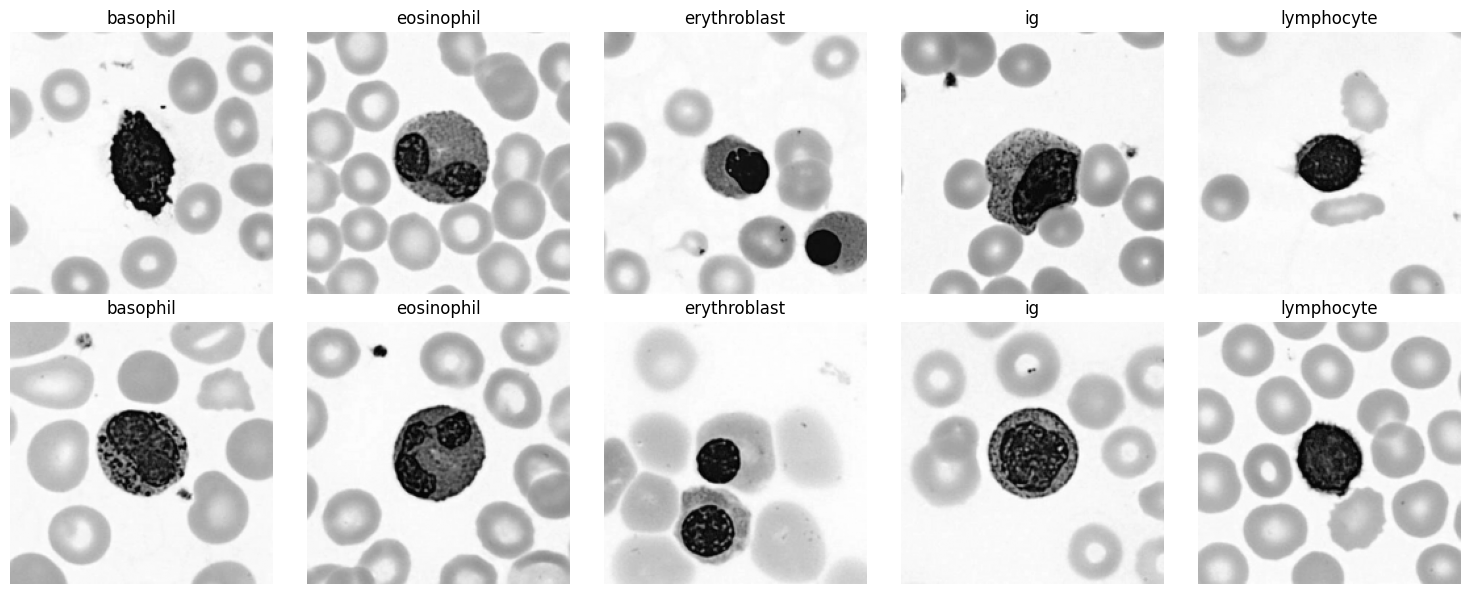

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(2, min(5, num_classes), figsize=(15, 6))
if num_classes == 1:
    axes = axes.reshape(-1, 1)

for i in range(min(num_classes, 5)):
    # Find first two images of this class
    class_id = i + 1
    idx = np.where(y_train == class_id)[0][:2]

    for j, img_idx in enumerate(idx):
        ax = axes[j, i] if num_classes > 1 else axes[j]
        ax.imshow(X_train[img_idx].squeeze(), cmap='gray')
        ax.set_title(f"{class_names[i]}")
        ax.axis('off')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/plots/sample_images.png", dpi=150, bbox_inches='tight')
plt.show()

## 4.5. Visualize Image Processing Pipeline

This section shows the effect of preprocessing: Original → Grayscale → Inverted Segmentation

Skipping class 'basophil' due to no image files found.
Skipping class 'erythroblast' due to no image files found.
Skipping class 'ig' due to no image files found.
Skipping class 'lymphocyte' due to no image files found.


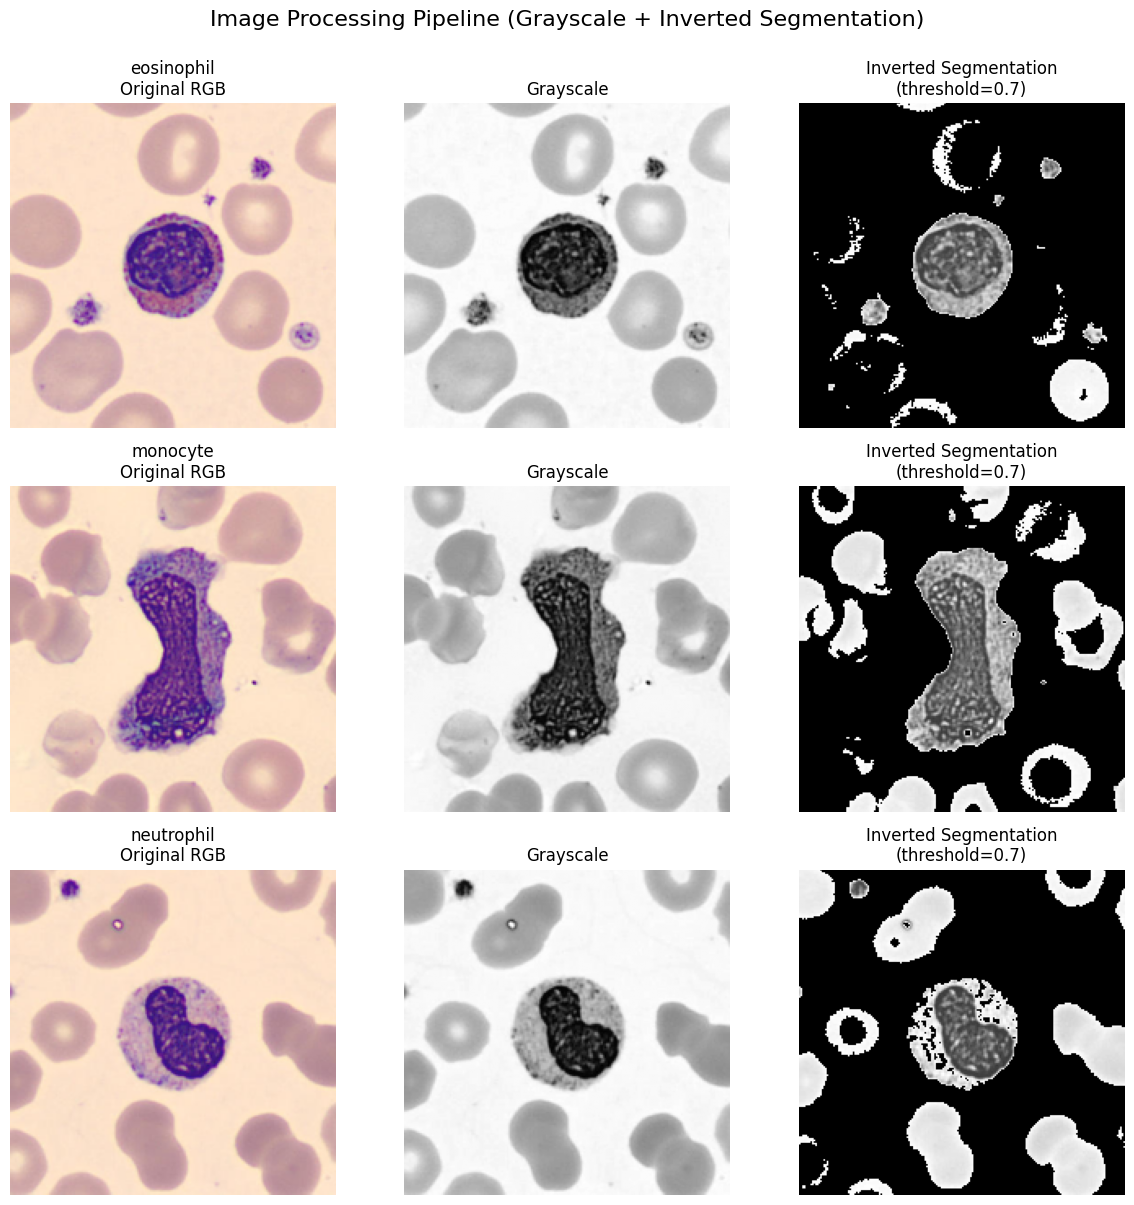

✅ Processing pipeline visualization saved to: ./artifacts_grey/plots/processing_pipeline.png


In [ ]:
# Load a few original images to show processing steps
def visualize_processing_pipeline(dataset_dir, class_names, num_samples=3):
    """Visualize the image processing pipeline: Original RGB → Grayscale → Inverted Segmentation."""

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    sample_count = 0
    for cls_idx, cls_name in enumerate(class_names):
        if sample_count >= num_samples:
            break

        folder = Path(dataset_dir) / cls_name
        files = sorted([p for p in folder.iterdir() if p.suffix.lower() in IMG_EXTS])

        # Check if there are files in the directory
        if not files:
            print(f"Skipping class '{cls_name}' due to no image files found.")
            continue

        # Take first image from this class
        img_path = files[0]

        # Step 1: Original RGB
        im_rgb = Image.open(img_path).convert("RGB")
        im_rgb_resized = im_rgb.resize((IMG_SIZE, IMG_SIZE))
        arr_rgb = np.asarray(im_rgb_resized, dtype=np.float32) / 255.0

        # Step 2: Grayscale
        im_gray = im_rgb_resized.convert('L')
        arr_gray = np.asarray(im_gray, dtype=np.float32) / 255.0

        # Step 3: Apply inverted segmentation
        arr_segmented = segment_image_inverted(arr_gray, threshold=SEGMENTATION_THRESHOLD)

        # Plot
        axes[sample_count, 0].imshow(arr_rgb)
        axes[sample_count, 0].set_title(f"{cls_name}\nOriginal RGB")
        axes[sample_count, 0].axis('off')

        axes[sample_count, 1].imshow(arr_gray, cmap='gray')
        axes[sample_count, 1].set_title(f"Grayscale")
        axes[sample_count, 1].axis('off')

        axes[sample_count, 2].imshow(arr_segmented, cmap='gray')
        axes[sample_count, 2].set_title(f"Inverted Segmentation\n(threshold={SEGMENTATION_THRESHOLD})")
        axes[sample_count, 2].axis('off')

        im_rgb.close()
        sample_count += 1

    plt.suptitle('Image Processing Pipeline (Grayscale + Inverted Segmentation)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/processing_pipeline.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Processing pipeline visualization saved to: {OUT_DIR}/plots/processing_pipeline.png")

# Visualize processing for 3 sample images
visualize_processing_pipeline(DATASET_DIR, class_names, num_samples=min(3, num_classes))

## 5. Model Building Functions

In [ ]:
def build_cnn(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Block 1
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

    # Block 2
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)

    # Block 3
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)

    # Head: GAP + small dense
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return models.Model(inputs, outputs, name="tiny_cnn_regularized")

def build_logreg_baseline(input_shape, num_classes):
    """Build a logistic regression baseline."""
    return tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(num_classes, activation="sigmoid")
    ])

print("Model building functions loaded!")

Model building functions loaded!


## 6. Training and Evaluation Functions

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """Train a model and plot training curves."""
    # Convert labels to categorical
    y_train_cat = to_categorical(y_train - 1, num_classes=num_classes)
    y_val_cat = to_categorical(y_val - 1, num_classes=num_classes)

    # Compile model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train model
    print(f"\nTraining {model_name}...")
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Plot accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_training.png", dpi=150, bbox_inches='tight')
    plt.show()

    return history

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and generate confusion matrix and classification report."""
    # Get predictions
    y_true = (y_test - 1).astype(int)
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Test Accuracy: {acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.colorbar()

    ticks = np.arange(num_classes)
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/plots/{model_name}_cm.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(f"\n{model_name} Classification Report:")
    print(report)

    # Save report to file
    with open(f"{OUT_DIR}/reports/{model_name}_report.txt", "w") as f:
        f.write(f"Test Accuracy: {acc:.4f}\n\n")
        f.write(report)

    return acc

print("Training and evaluation functions loaded!")

Training and evaluation functions loaded!


## 7. Train CNN Model

Model: "tiny_cnn_regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 200, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 200, 200, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 200, 200, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,280,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,299,112 (4.96 MB)

 Trainable params: 1,298,952 (4.96 MB)

 Non-trainable params: 160 (640.00 B)


Training tiny_cnn...
Epoch 1/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.5423 - loss: 1.5857 - val_accuracy: 0.6626 - val_loss: 0.9361
Epoch 2/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8385 - loss: 0.4503 - val_accuracy: 0.8167 - val_loss: 0.5905
Epoch 3/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8799 - loss: 0.3315 - val_accuracy: 0.7371 - val_loss: 0.8985
Epoch 4/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9199 - loss: 0.2331 - val_accuracy: 0.2266 - val_loss: 4.9075
Epoch 5/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9316 - loss: 0.1956 - val_accuracy: 0.8604 - val_loss: 0.4724
Epoch 6/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9446 - loss: 0.1614 - val_accuracy: 0.8615 - val_loss: 0.4536
Epoch 7/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9605 - loss: 0.1112 - val_accuracy: 0.8471 - val_loss: 0.5357
Epoch 8/8
748/748 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9626 - l

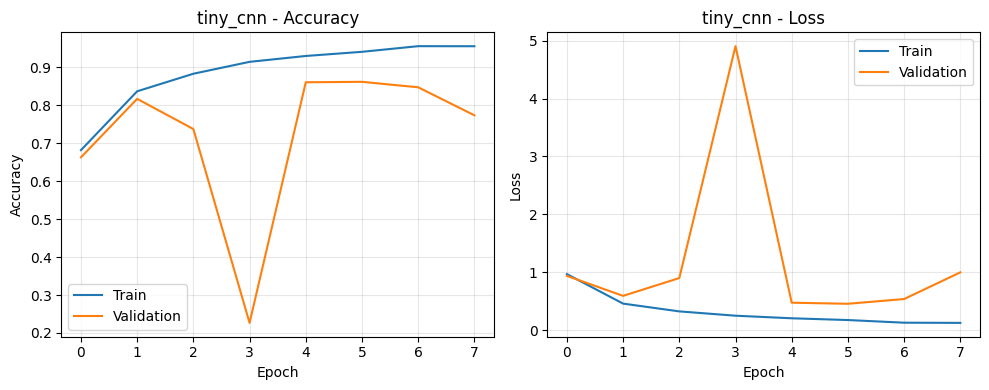


CNN model saved to: ./artifacts_grey/models/tiny_cnn.keras


In [ ]:
# Build CNN model (note: input shape is now (IMG_SIZE, IMG_SIZE, 1) for grayscale)
input_shape = (IMG_SIZE, IMG_SIZE, 1)
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.summary()

# Control the subset of training data to be used to develop model architecture
X_train_subset, y_train_subset = testing_subset(X_train, y_train, size=700)

X_val_subset, y_val_subset = testing_subset(X_val, y_val, size=150)

# Train CNN
cnn_history = train_model(cnn_model, X_train, y_train, X_val, y_val, "tiny_cnn")
#cnn_history = train_model(cnn_model, X_train_subset, y_train_subset, X_val_subset, y_val_subset, "tiny_cnn")

# Save model
cnn_model.save(f"{OUT_DIR}/models/tiny_cnn.keras")
print(f"\nCNN model saved to: {OUT_DIR}/models/tiny_cnn.keras")

## 8. Evaluate CNN Model


tiny_cnn Test Accuracy: 0.7820


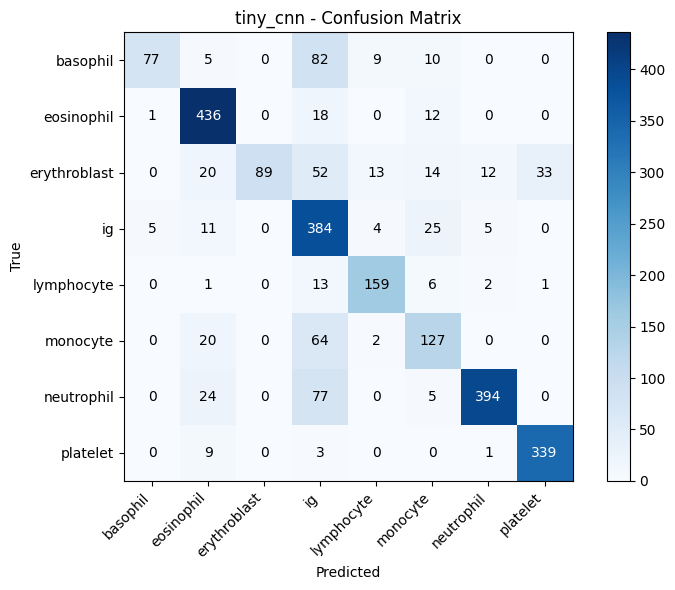


tiny_cnn Classification Report:
              precision    recall  f1-score   support

    basophil     0.9277    0.4208    0.5789       183
  eosinophil     0.8289    0.9336    0.8781       467
erythroblast     1.0000    0.3820    0.5528       233
          ig     0.5541    0.8848    0.6815       434
  lymphocyte     0.8503    0.8736    0.8618       182
    monocyte     0.6382    0.5962    0.6165       213
  neutrophil     0.9517    0.7880    0.8621       500
    platelet     0.9088    0.9631    0.9352       352

    accuracy                         0.7820      2564
   macro avg     0.8325    0.7303    0.7459      2564
weighted avg     0.8256    0.7820    0.7757      2564



In [ ]:
cnn_accuracy = evaluate_model(cnn_model, X_test, y_test, "tiny_cnn")

## 9. Train Logistic Regression Baseline

In [ ]:
# Build logistic regression model
logreg_model = build_logreg_baseline(input_shape, num_classes)
logreg_model.summary()

# Train logistic regression
logreg_history = train_model(logreg_model, X_train, y_train, X_val, y_val, "logreg")

# Save model
logreg_model.save(f"{OUT_DIR}/models/logreg.keras")
print(f"\nLogistic regression model saved to: {OUT_DIR}/models/logreg.keras")

## 10. Evaluate Logistic Regression Baseline

In [ ]:
logreg_accuracy = evaluate_model(logreg_model, X_test, y_test, "logreg")

## 11. Compare Models

In [ ]:
# Compare model accuracies
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Tiny CNN Test Accuracy:        {cnn_accuracy:.4f}")
print(f"Logistic Regression Accuracy:  {logreg_accuracy:.4f}")
print(f"Improvement:                   {(cnn_accuracy - logreg_accuracy):.4f}")
print("="*50)

# Bar plot comparison
plt.figure(figsize=(8, 5))
models = ['Logistic Regression', 'Tiny CNN']
accuracies = [logreg_accuracy, cnn_accuracy]
colors = ['#FF6B6B', '#4ECDC4']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison (Grayscale + Inverted Segmentation)')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/plots/model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()